# DQN Training for Taxi-v3 (Baseline)

This notebook trains a DQN agent using **baseline hyperparameters** (before tuning).

**Note**: For optimized hyperparameters, see notebook `06_dqn_training_optimized.ipynb` (run after hyperparameter tuning).

In [ ]:
import sys

sys.path.append('..')

from pathlib import Path

import gymnasium as gym
import imageio
import numpy as np
import yaml

from reinforcement_learning_taxi.agents.dqn_agent import DQNAgent
from reinforcement_learning_taxi.environments import TaxiFeatureWrapper, make_taxi_env
from reinforcement_learning_taxi.evaluation.metrics import evaluate_agent
from reinforcement_learning_taxi.training.dqn_trainer import DQNTrainer
from reinforcement_learning_taxi.visualization.training_plots import plot_episode_length, plot_learning_curve

## Load Configuration

In [2]:
with open('../src/reinforcement_learning_taxi/configs/dqn_config_baseline.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
print(f"  Environment: {config['environment']['name']}")
print(f"  Training timesteps: {config['training']['total_timesteps']}")
print(f"  Policy: {config['agent']['policy']}")
print(f"  Learning rate: {config['agent']['learning_rate']}")
print(f"  Buffer size: {config['agent']['buffer_size']}")
print(f"  Seed: {config['agent']['seed']}")

Configuration loaded:
  Environment: Taxi-v3
  Training timesteps: 200000
  Policy: MlpPolicy
  Learning rate: 0.0001
  Buffer size: 100000
  Seed: 42


## Initialize Environment and Agent

In [3]:
# Create environment with feature wrapper for proper observation encoding
env = make_taxi_env(
    render_mode=config['environment'].get('render_mode'),
    use_feature_wrapper=True,  # Converts discrete obs to 19-dim feature vector
)

print(f"Environment observation space: {env.observation_space}")
print(f"Environment action space: {env.action_space}")

agent = DQNAgent(
    env=env,
    policy=config['agent']['policy'],
    learning_rate=config['agent']['learning_rate'],
    buffer_size=config['agent']['buffer_size'],
    learning_starts=config['agent']['learning_starts'],
    batch_size=config['agent']['batch_size'],
    gamma=config['agent']['gamma'],
    train_freq=config['agent']['train_freq'],
    gradient_steps=config['agent']['gradient_steps'],
    target_update_interval=config['agent']['target_update_interval'],
    exploration_fraction=config['agent']['exploration_fraction'],
    exploration_initial_eps=config['agent']['exploration_initial_eps'],
    exploration_final_eps=config['agent']['exploration_final_eps'],
    policy_kwargs=config['agent']['policy_kwargs'],
    verbose=config['agent']['verbose'],
    seed=config['agent']['seed'],
)

print("DQN agent initialized with stable-baselines3")

Environment observation space: Box(0.0, 1.0, (19,), float32)
Environment action space: Discrete(6)
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
DQN agent initialized with stable-baselines3


## Train Agent

In [4]:
trainer = DQNTrainer(
    env=env,
    agent=agent,
    log_dir=config['training']['log_dir'],
    checkpoint_freq=config['training']['checkpoint_freq'],
    eval_freq=config['training']['eval_freq'],
    eval_episodes=config['training']['eval_episodes'],
)

print("Starting training...")
stats = trainer.train(total_timesteps=config['training']['total_timesteps'])

print("\nTraining completed!")
print(f"  Total timesteps: {stats['total_timesteps']}")
print(f"  Training time: {stats['training_time']:.2f} seconds")
print(f"  Episodes completed: {len(stats['episode_rewards'])}")

Starting training...
Eval num_timesteps=5000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -200     |
| rollout/            |          |
|    exploration_rate | 0.918    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.262    |
|    n_updates        | 999      |
----------------------------------
New best mean reward!
Eval num_timesteps=10000, episode_reward=-200.00 +/- 0.00
Episode length: 200.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 200      |
|    mean_reward      | -200     |
| rollout/            |          |
|    exploration_rate | 0.835    |
| time/               |          |
|    total_timesteps  | 10000    |
| train/              |          |
|    lea

## Visualize Training Progress

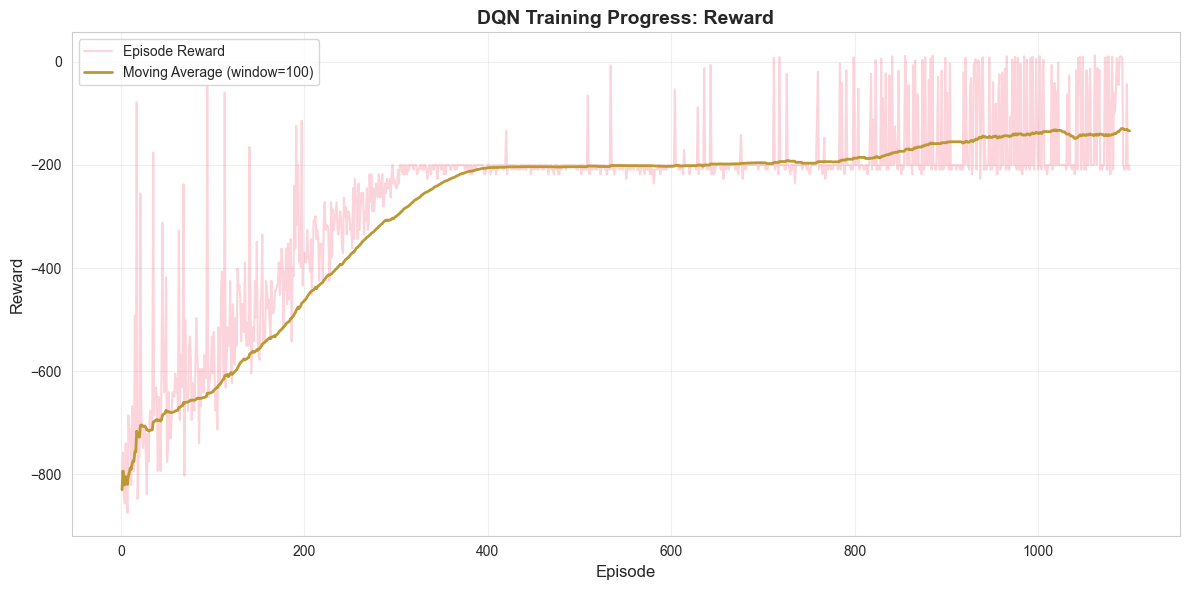

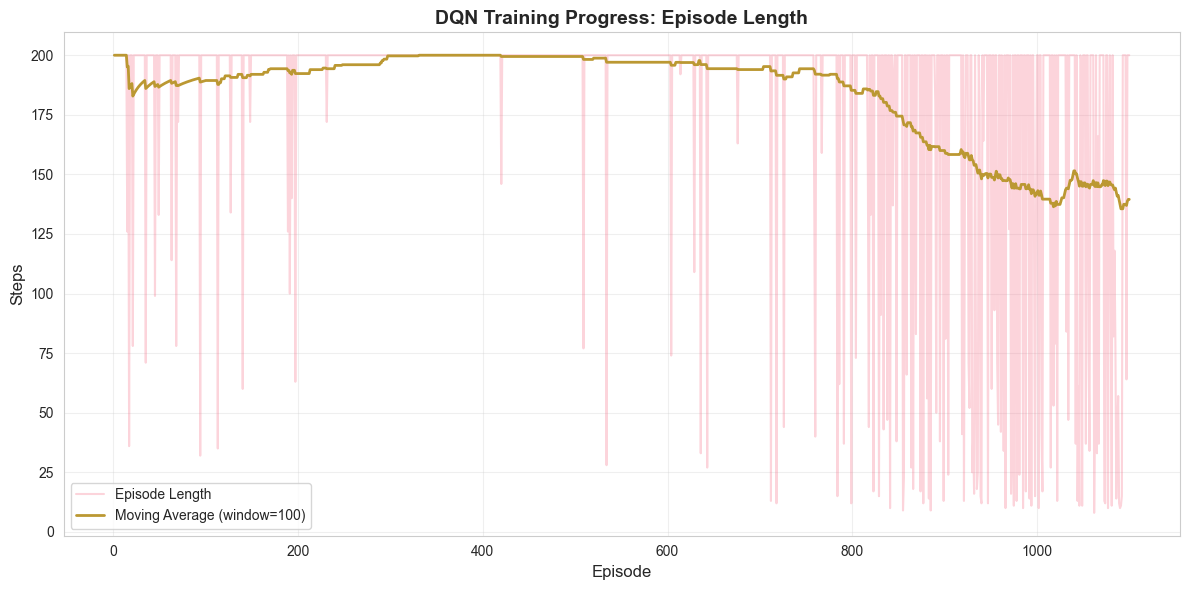

Training plots saved to ../results/logs/dqn_baseline/plots


In [5]:
plot_dir = Path(config['training']['log_dir']) / 'plots'
plot_dir.mkdir(parents=True, exist_ok=True)

if stats['episode_rewards']:
    plot_learning_curve(
        stats['episode_rewards'],
        title="DQN Training Progress: Reward",
        save_path=plot_dir / "learning_curve.png",
    )

    plot_episode_length(
        stats['episode_lengths'],
        title="DQN Training Progress: Episode Length",
        save_path=plot_dir / "episode_length.png",
    )

    print(f"Training plots saved to {plot_dir}")
else:
    print("No episode data available for plotting")

## Evaluate Trained Agent

In [6]:
eval_results = evaluate_agent(
    agent=agent,
    env=env,
    n_episodes=config['evaluation']['n_episodes'],
    deterministic=config['evaluation']['deterministic'],
)

print("Evaluation Results:")
print(f"  Mean reward: {eval_results['mean_reward']:.2f} ± {eval_results['std_reward']:.2f}")
print(f"  Success rate: {eval_results['success_rate']:.2%}")
print(f"  Mean episode length: {eval_results['mean_length']:.2f}")
print(f"  Reward range: [{eval_results['min_reward']:.2f}, {eval_results['max_reward']:.2f}]")

Evaluation Results:
  Mean reward: -139.65 ± 94.89
  Success rate: 28.80%
  Mean episode length: 145.70
  Reward range: [-200.00, 15.00]


## Test on Sample Episode

In [9]:
# Save 10 episodes into one video
render_dir = Path('../results/renders')
render_dir.mkdir(parents=True, exist_ok=True)

env_render = gym.make(config['environment']['name'], render_mode='rgb_array')
env_render = TaxiFeatureWrapper(env_render)

video_path = render_dir / 'dqn_baseline_10runs.mp4'
fps = 10
pause_frames = fps

seeds = [999 + i for i in range(10)]
episode_stats = []

with imageio.get_writer(video_path, fps=fps) as writer:
    for i, seed in enumerate(seeds, start=1):
        state, _ = env_render.reset(seed=seed)
        frame = env_render.render()
        writer.append_data(frame)
        done = False
        steps = 0
        ep_reward = 0
        while not done and steps < 200:
            action, _ = agent.predict(state, deterministic=True)
            if isinstance(action, np.ndarray):
                action = int(action.item())
            state, reward, terminated, truncated, _ = env_render.step(action)
            frame = env_render.render()
            writer.append_data(frame)
            done = terminated or truncated
            ep_reward += reward
            steps += 1
        success = ep_reward > 0
        episode_stats.append((steps, ep_reward, success))
        print(f'Episode {i}: steps={steps}, reward={ep_reward}, success={success}')
        if i != len(seeds):
            for _ in range(pause_frames):
                writer.append_data(frame)

env_render.close()
mean_reward = sum(r for _s, r, _su in episode_stats) / len(episode_stats)
mean_steps = sum(s for s, _r, _su in episode_stats) / len(episode_stats)
success_rate = sum(1 for _s, _r, su in episode_stats if su) / len(episode_stats)
print(f'Video saved to {video_path}')
print(f'Summary: mean_reward={mean_reward:.2f}, mean_steps={mean_steps:.2f}, success_rate={success_rate:.2%}')


/Users/azernaczuk/Documents/0sobiste/github/reinforcement_learning_taxi/.venv/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (550, 350) to (560, 352) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Episode 1: steps=10, reward=11, success=True
Episode 2: steps=200, reward=-200, success=False
Episode 3: steps=200, reward=-200, success=False
Episode 4: steps=13, reward=8, success=True
Episode 5: steps=200, reward=-200, success=False
Episode 6: steps=10, reward=11, success=True
Episode 7: steps=200, reward=-200, success=False
Episode 8: steps=9, reward=12, success=True
Episode 9: steps=200, reward=-200, success=False
Episode 10: steps=200, reward=-200, success=False
Video saved to ../results/renders/dqn_baseline_10runs.mp4
Summary: mean_reward=-115.80, mean_steps=124.20, success_rate=40.00%
